## What I did?
- reimplement Lipschitz regularizer proposed in [this paper](https://arxiv.org/abs/2202.08345). 
- [x] writing practice. some short para to summerzie the paper, [link here](https://drive.google.com/file/d/1gt-e7cnY1we_1PZegl8uC3beHdr3QFEW/view?usp=sharing).

- toy example: train a 2D SDF model w or without the proposed Lipschitz regularizer with 2-dim latent code for two "shapes". $f: x, z --> y$ where x is 2D coord, z is a 2-dim latent code.
- Data: convert MNIST to 2D Sdf signal. select 2 images ("1", "7"), with two manually specifed z ((0, 0), (1, 1)). 
- Model: 3 layer SDF, copied from DeepSDF. 
- Trainer: 5000 iters, 400 batch size. 

## Results
- for interpolateion experiments, qualitative difference is marginal.
- for optimization experiments, both success when z starts closer from  to target z.  But BASELINE manages to always converge to the target z.

## Potential bugs
- `alpha` nubmer.
- `tanh` activation? as `tanh` is not Lipschitz continuous and blow up the whole network. 
- I did not implemente the weightnorm correctly?
- MNIST 1 and 7 is similar? 
- different behaviour with z's dimensionality? 

## Some Implementation details 
- DeeSDF already had `weight_norm` option. So it's rather easy to add the loss.
- `skfmm.distance` can calculate SDF from 2D fg masks. 
- 2D is a good toy example to test ideas -- saves time to visualize.
- pl is good to prototype, though it took me lots of time to figure out wandblogger and wandb.log....
- This is my first code developed by jupyter notebook....

## Some thoughts
- As the paper says, there are multiple ways to regularize lipschitz coeff. However, the experiments are not very rigorous. Not sure how much baselines are tuned. 
- Right now, the formulation encourage smoothnes wrt the input, regardless of inputs being coordinate x or latent z. Sometimes, we may want smooth latent code but sharp geometry. e.g. lots of crispy shapes, or vice versa. 
- Not sure how well the algorithm could handle high-dimensional large scale data. 
    + is `alpha` senstive to z_dim? feature dim? 
    + when dataset is large, this may squeeze the latent space for each shape. In that case, we don't want the space oversmooth, leading to different optimal `alpha`. Same with smoothness vs shaprness within each geometry.
- The idea is not limited to neural implicit field. In general, it just encourage the output space beiing smooth wrt input. If we want to generalize it, how to deal with other layers, e.g. batch norm? layer norm? conv? 

In [1]:
%load_ext autoreload
%autoreload 2

import torch
import torchvision.datasets 
import numpy as np
import seaborn as sb
import matplotlib.pyplot as plt

import pytorch_lightning as pl
import wandb
from data import ImageSdf
from decoder import SdfDec

np.random.seed(123)
torch.manual_seed(123)
def load_images(N=2):
    """
    Returns (N, 28, 28)?? of Bool? 
    """
    dataset = torchvision.datasets.MNIST('.', False, download=True)
    
    image_list = []
    for i in range(N):
        image, label = dataset[np.random.randint(0, len(dataset))]
        image = np.array(image)
        print(image.shape)
        image_list.append(image)
    return image_list
image_list = load_images()

(28, 28)
(28, 28)



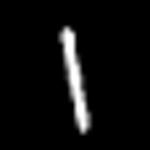
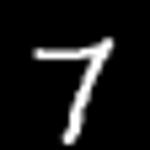


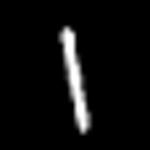
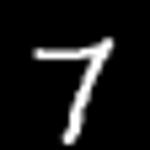

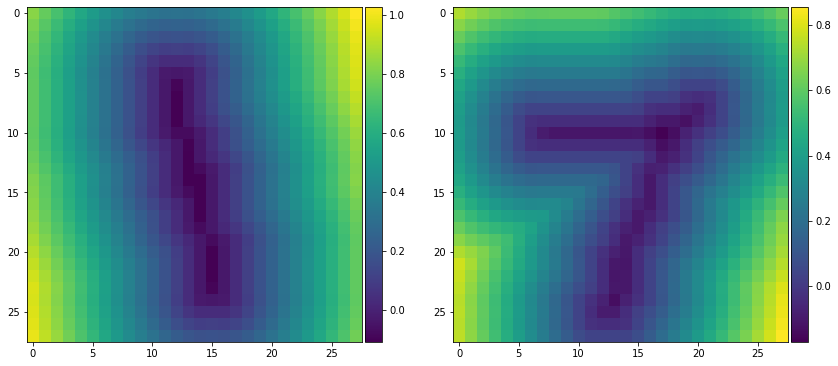

In [2]:
z_dim = 2
dataset = ImageSdf(image_list, z_dim)

2D sdf loader

In [3]:
%matplotlib inline
import wandb
from torch.utils.data import DataLoader
from pytorch_lightning.loggers import WandbLogger


train_loader = DataLoader(dataset, batch_size=None)
val_loader = DataLoader(dataset, batch_size=None)



In [4]:
wandb.finish()
# wandb.init(project='lipschitz', name='wn:none')
wandb_logger = WandbLogger(project='lipschitz', log_model=True, name='wn:none', save_dir='log/',)

wn_model = SdfDec(0, z_dim, [64, 64, 64,], 2, weight_norm='none')
# training
trainer = pl.Trainer(gpus=1, 
    logger=wandb_logger, 
    max_steps=5000,
    check_val_every_n_epoch=100,
    )
trainer.fit(wn_model, train_loader, val_loader)



GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name | Type    | Params
---------------------------------
0 | dec  | Decoder | 8.7 K 
---------------------------------
8.7 K     Trainable params
0         Non-trainable params
8.7 K     Total params
0.035     Total estimated model params size (MB)
/private/home/yufeiy2/.conda/envs/lasr/lib/python3.8/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:631: UserWarning: Checkpoint directory log/wn:none/version_None/checkpoints exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")


Validation sanity check: 0it [00:00, ?it/s]

/private/home/yufeiy2/.conda/envs/lasr/lib/python3.8/site-packages/pytorch_lightning/trainer/data_loading.py:132: UserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 80 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/private/home/yufeiy2/.conda/envs/lasr/lib/python3.8/site-packages/torch/nn/functional.py:3385: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn("Default grid_sample and affine_grid behavior has changed "
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: condinv-ssl (use `wandb login --relogi

/private/home/yufeiy2/.conda/envs/lasr/lib/python3.8/site-packages/pytorch_lightning/trainer/data_loading.py:132: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 80 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/private/home/yufeiy2/.conda/envs/lasr/lib/python3.8/site-packages/pytorch_lightning/trainer/data_loading.py:432: UserWarning: The number of training samples (2) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

/private/home/yufeiy2/.conda/envs/lasr/lib/python3.8/site-packages/torch/nn/functional.py:3385: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn("Default grid_sample and affine_grid behavior has changed "


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

In [5]:
from vis_utils import show_images
def interpolate(z1, z2, model, title='interpolate', N=10):
    device = z1.device
    alpha = torch.linspace(0, 1, N, device=device).unsqueeze(-1)
    z = z1 * alpha + z2 * (1 - alpha)  # (N, D?)

    image_list = []
    for n in range(N):
        image = model.vis_z(z[n:n+1])
        image_list.append(image)
    
    image_list = torch.cat(image_list, 0)
    image = image_list.cpu().detach().numpy()[:, 0]
    print(image.shape)
    fig = show_images(image, True)
    fig.set_dpi(100)

    # wandb.log({'chart': plt})
    print(model.global_step)
    wandb.log({'interpolate': wandb.Image(fig, caption=title)}, step=model.global_step)
    plt.savefig('docs/%s.png' % title)
    return plt


(10, 28, 28)


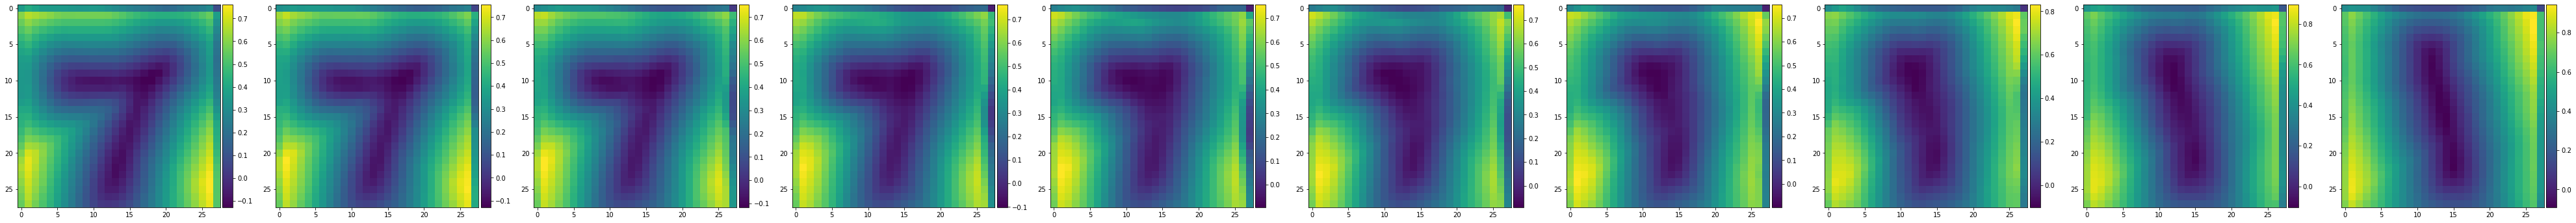

5000


<module 'matplotlib.pyplot' from '/private/home/yufeiy2/.conda/envs/lasr/lib/python3.8/site-packages/matplotlib/pyplot.py'>

<Figure size 432x288 with 0 Axes>

In [6]:
device = 'cuda:0'
wn_model = wn_model.to(device)
z1 = torch.FloatTensor([[0, ]]).to(device).repeat(1, z_dim)
z2 = torch.FloatTensor([[1, ]]).to(device).repeat(1, z_dim)
interpolate(z1, z2, wn_model, 'wo regulrizer')

Output wo regularizer: 
Interpolation results, z_dim=2 | model 
--- |  --- 
![](docs/wo_reg.png) | [model](log/wn\:none/version_None/checkpoints/epoch\=2499-step\=4999.ckpt)


In [7]:
wandb.finish()
alpha = 1
wandb_logger = WandbLogger(project='lipschitz', log_model=True, name='wn:lip_%g' % alpha)
lip_model = SdfDec(alpha, z_dim, [64, 64, 64,], 2, weight_norm='lip', norm_layers=(0, 1, 2, 3))
# training
trainer = pl.Trainer(gpus='0', 
    logger=wandb_logger, 
    max_steps=5000,
    check_val_every_n_epoch=100,
    )
trainer.fit(lip_model, train_loader, val_loader)

train_lip,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_loss,█▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_sdf,█▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_lip,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_sdf,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_lip,0
train_loss,0.00051
train_sdf,0.00051
val_lip,0
val_loss,0.00083


GPU available: True, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
/private/home/yufeiy2/.conda/envs/lasr/lib/python3.8/site-packages/pytorch_lightning/trainer/trainer.py:1584: UserWarning: GPU available but not used. Set the gpus flag in your trainer `Trainer(gpus=1)` or script `--gpus=1`.
  rank_zero_warn(

  | Name | Type    | Params
---------------------------------
0 | dec  | Decoder | 8.7 K 
---------------------------------
8.7 K     Trainable params
0         Non-trainable params
8.7 K     Total params
0.035     Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

/private/home/yufeiy2/.conda/envs/lasr/lib/python3.8/site-packages/pytorch_lightning/trainer/data_loading.py:132: UserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 80 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


/private/home/yufeiy2/.conda/envs/lasr/lib/python3.8/site-packages/pytorch_lightning/trainer/data_loading.py:132: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 80 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/private/home/yufeiy2/.conda/envs/lasr/lib/python3.8/site-packages/pytorch_lightning/trainer/data_loading.py:432: UserWarning: The number of training samples (2) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

/private/home/yufeiy2/.conda/envs/lasr/lib/python3.8/site-packages/torch/nn/functional.py:3385: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn("Default grid_sample and affine_grid behavior has changed "


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

(10, 28, 28)


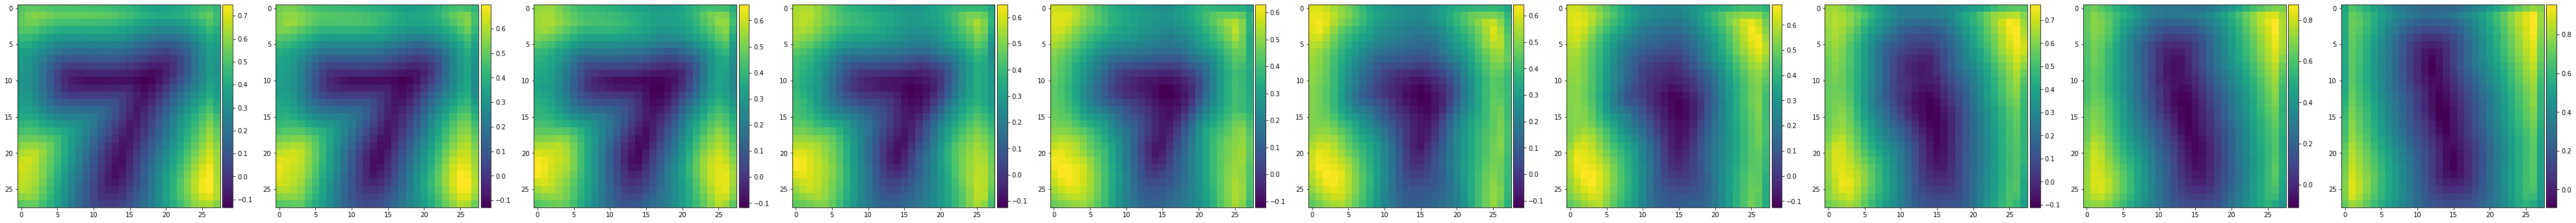

5000


<module 'matplotlib.pyplot' from '/private/home/yufeiy2/.conda/envs/lasr/lib/python3.8/site-packages/matplotlib/pyplot.py'>

<Figure size 432x288 with 0 Axes>

In [8]:
lip_model = lip_model.to(device)
interpolate(z1, z2, lip_model)

Output $\alpha = 1$: 
Interpolation results, z_dim=2 | model 
--- |  --- 
![](docs/lip.png) | [model](log/wn\:lip_1/version_None/checkpoints/epoch\=2499-step\=4999-v1.ckpt)


print someth



train_lip,█▆▄▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_loss,█▆▄▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_sdf,█▄▃▂▂▁▁▂▁▂▁▁▁▁▁▂▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_lip,█▄▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_sdf,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_lip,0.00011
train_loss,0.00123
train_sdf,0.00112
val_lip,0.00011
val_loss,0.00152


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name | Type    | Params
---------------------------------
0 | dec  | Decoder | 8.7 K 
---------------------------------
8.7 K     Trainable params
0         Non-trainable params
8.7 K     Total params
0.035     Total estimated model params size (MB)
/private/home/yufeiy2/.conda/envs/lasr/lib/python3.8/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:631: UserWarning: Checkpoint directory log/alpha=1/version_None/checkpoints exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")


Validation sanity check: 0it [00:00, ?it/s]

/private/home/yufeiy2/.conda/envs/lasr/lib/python3.8/site-packages/pytorch_lightning/trainer/data_loading.py:132: UserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 80 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


/private/home/yufeiy2/.conda/envs/lasr/lib/python3.8/site-packages/pytorch_lightning/trainer/data_loading.py:132: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 80 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/private/home/yufeiy2/.conda/envs/lasr/lib/python3.8/site-packages/pytorch_lightning/trainer/data_loading.py:432: UserWarning: The number of training samples (2) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

/private/home/yufeiy2/.conda/envs/lasr/lib/python3.8/site-packages/torch/nn/functional.py:3385: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn("Default grid_sample and affine_grid behavior has changed "


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

(10, 28, 28)


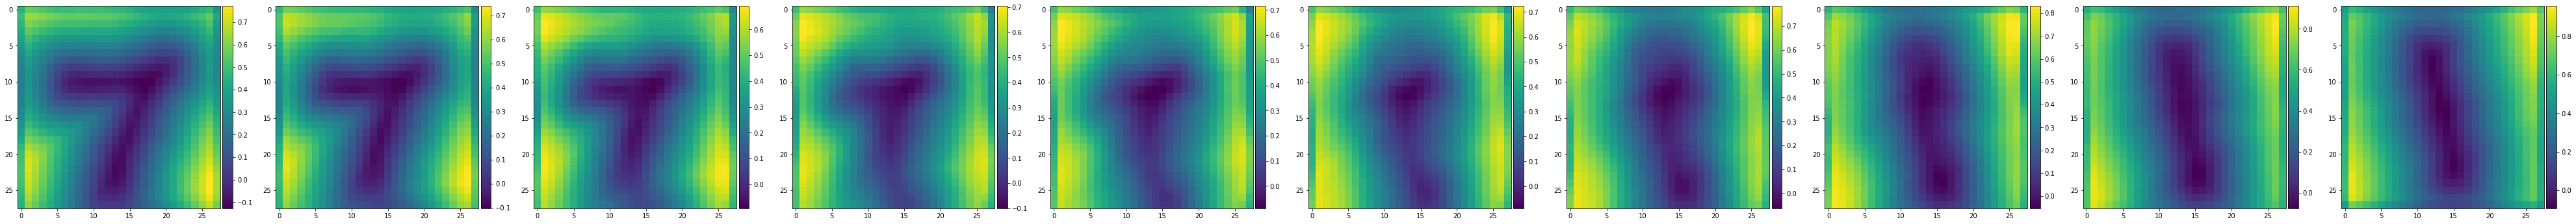

5000
print someth



a,▁
train_lip,█▆▄▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_loss,█▆▄▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_sdf,█▆▄▄▂▃▃▃▃▂▂▃▂▂▂▁▂▂▂▂▂▂▂▁▂▂▂▁▂▂▂▁▁▂▁▂▁▁▁▂
val_lip,█▄▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▄▃▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_sdf,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
a,1
train_lip,0.00012
train_loss,0.00123
train_sdf,0.00111


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name | Type    | Params
---------------------------------
0 | dec  | Decoder | 8.7 K 
---------------------------------
8.7 K     Trainable params
0         Non-trainable params
8.7 K     Total params
0.035     Total estimated model params size (MB)
/private/home/yufeiy2/.conda/envs/lasr/lib/python3.8/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:631: UserWarning: Checkpoint directory log/alpha=0.1/version_None/checkpoints exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")


Validation sanity check: 0it [00:00, ?it/s]

/private/home/yufeiy2/.conda/envs/lasr/lib/python3.8/site-packages/pytorch_lightning/trainer/data_loading.py:132: UserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 80 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


/private/home/yufeiy2/.conda/envs/lasr/lib/python3.8/site-packages/pytorch_lightning/trainer/data_loading.py:132: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 80 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/private/home/yufeiy2/.conda/envs/lasr/lib/python3.8/site-packages/pytorch_lightning/trainer/data_loading.py:432: UserWarning: The number of training samples (2) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

/private/home/yufeiy2/.conda/envs/lasr/lib/python3.8/site-packages/torch/nn/functional.py:3385: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn("Default grid_sample and affine_grid behavior has changed "


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

(10, 28, 28)


<Figure size 432x288 with 0 Axes>

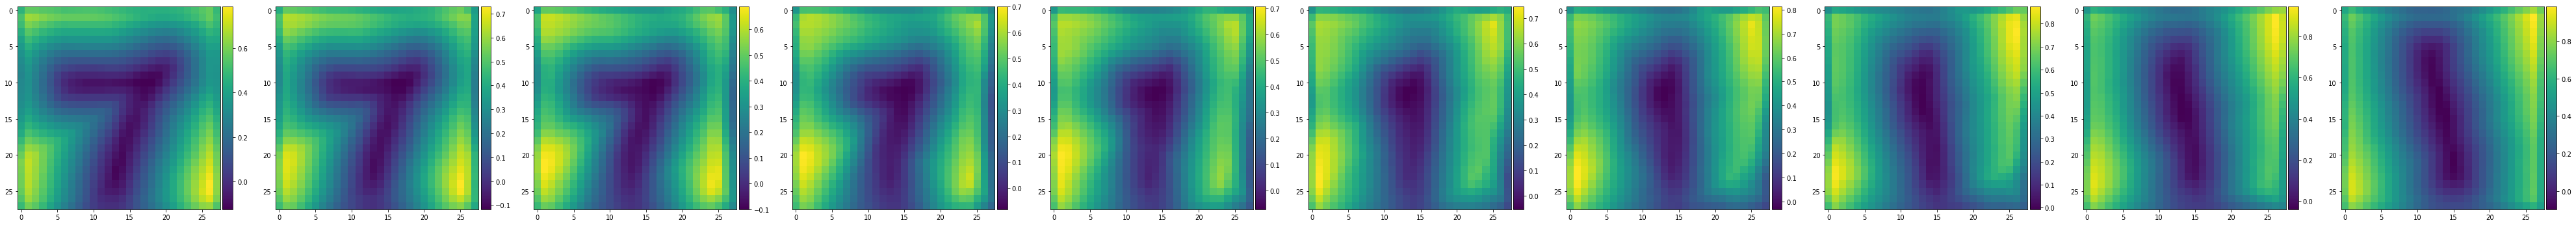

5000
print someth



a,▁
train_lip,█▆▄▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_loss,█▆▄▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_sdf,█▃▃▂▂▂▂▂▂▁▁▂▂▃▂▂▁▂▁▂▂▁▁▁▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁
val_lip,█▄▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_sdf,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
a,0.1
train_lip,1e-05
train_loss,0.0008
train_sdf,0.00079


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name | Type    | Params
---------------------------------
0 | dec  | Decoder | 8.7 K 
---------------------------------
8.7 K     Trainable params
0         Non-trainable params
8.7 K     Total params
0.035     Total estimated model params size (MB)
/private/home/yufeiy2/.conda/envs/lasr/lib/python3.8/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:631: UserWarning: Checkpoint directory log/alpha=0.01/version_None/checkpoints exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")


Validation sanity check: 0it [00:00, ?it/s]

/private/home/yufeiy2/.conda/envs/lasr/lib/python3.8/site-packages/pytorch_lightning/trainer/data_loading.py:132: UserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 80 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


/private/home/yufeiy2/.conda/envs/lasr/lib/python3.8/site-packages/pytorch_lightning/trainer/data_loading.py:132: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 80 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/private/home/yufeiy2/.conda/envs/lasr/lib/python3.8/site-packages/pytorch_lightning/trainer/data_loading.py:432: UserWarning: The number of training samples (2) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

/private/home/yufeiy2/.conda/envs/lasr/lib/python3.8/site-packages/torch/nn/functional.py:3385: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn("Default grid_sample and affine_grid behavior has changed "


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

(10, 28, 28)


<Figure size 432x288 with 0 Axes>

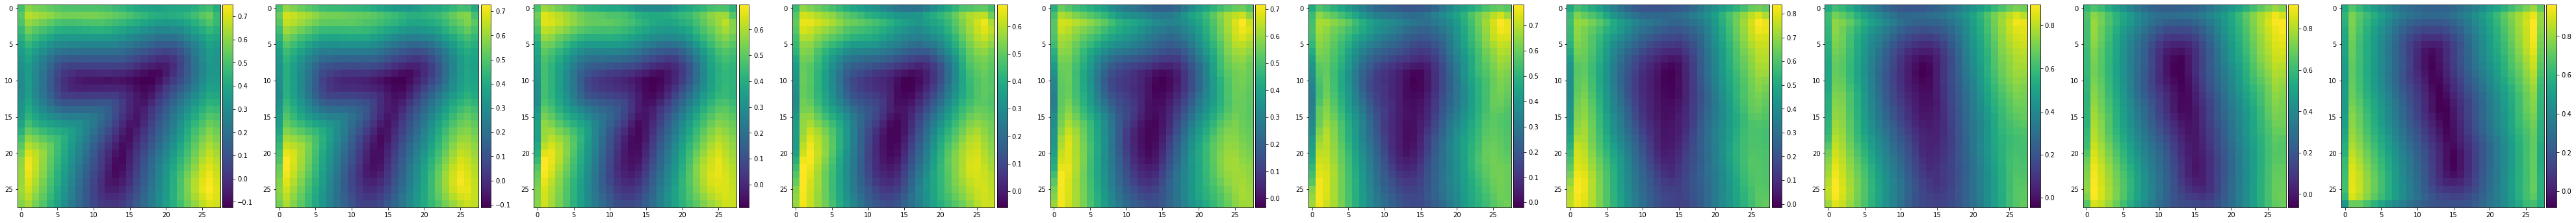

5000
print someth



a,▁
train_lip,█▇▅▄▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_loss,█▆▄▃▃▂▂▂▂▂▂▁▁▂▁▂▁▁▁▁▁▁▁▂▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁
train_sdf,█▄▄▂▄▃▂▃▂▂▃▂▂▃▂▃▂▂▁▂▂▂▂▂▂▁▂▂▂▂▁▁▁▁▁▂▁▂▂▁
val_lip,█▅▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_sdf,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
a,0.01
train_lip,0.0
train_loss,0.00069
train_sdf,0.00069


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name | Type    | Params
---------------------------------
0 | dec  | Decoder | 8.7 K 
---------------------------------
8.7 K     Trainable params
0         Non-trainable params
8.7 K     Total params
0.035     Total estimated model params size (MB)
/private/home/yufeiy2/.conda/envs/lasr/lib/python3.8/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:631: UserWarning: Checkpoint directory log/alpha=0.001/version_None/checkpoints exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")


Validation sanity check: 0it [00:00, ?it/s]

/private/home/yufeiy2/.conda/envs/lasr/lib/python3.8/site-packages/pytorch_lightning/trainer/data_loading.py:132: UserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 80 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


/private/home/yufeiy2/.conda/envs/lasr/lib/python3.8/site-packages/pytorch_lightning/trainer/data_loading.py:132: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 80 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/private/home/yufeiy2/.conda/envs/lasr/lib/python3.8/site-packages/pytorch_lightning/trainer/data_loading.py:432: UserWarning: The number of training samples (2) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

/private/home/yufeiy2/.conda/envs/lasr/lib/python3.8/site-packages/torch/nn/functional.py:3385: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn("Default grid_sample and affine_grid behavior has changed "


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

(10, 28, 28)


<Figure size 432x288 with 0 Axes>

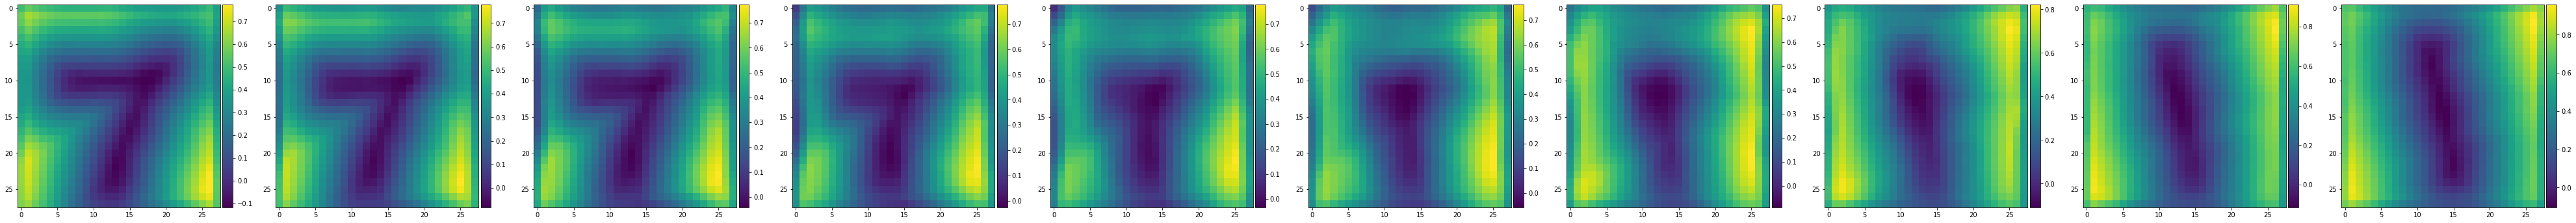

5000
print someth



a,▁
train_lip,█▇▅▄▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_loss,█▅▃▄▃▂▃▂▂▂▂▂▂▂▂▂▂▂▂▁▁▂▁▂▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁
train_sdf,█▄▂▄▃▂▄▂▂▂▂▂▂▂▂▂▂▃▂▂▁▂▁▂▂▁▂▂▁▁▁▁▁▁▁▁▁▁▁▁
val_lip,█▅▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_sdf,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
a,0.001
train_lip,0.0
train_loss,0.00103
train_sdf,0.00103


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name | Type    | Params
---------------------------------
0 | dec  | Decoder | 8.7 K 
---------------------------------
8.7 K     Trainable params
0         Non-trainable params
8.7 K     Total params
0.035     Total estimated model params size (MB)
/private/home/yufeiy2/.conda/envs/lasr/lib/python3.8/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:631: UserWarning: Checkpoint directory log/alpha=0.0001/version_None/checkpoints exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")


Validation sanity check: 0it [00:00, ?it/s]

/private/home/yufeiy2/.conda/envs/lasr/lib/python3.8/site-packages/pytorch_lightning/trainer/data_loading.py:132: UserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 80 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


/private/home/yufeiy2/.conda/envs/lasr/lib/python3.8/site-packages/pytorch_lightning/trainer/data_loading.py:132: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 80 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/private/home/yufeiy2/.conda/envs/lasr/lib/python3.8/site-packages/pytorch_lightning/trainer/data_loading.py:432: UserWarning: The number of training samples (2) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

/private/home/yufeiy2/.conda/envs/lasr/lib/python3.8/site-packages/torch/nn/functional.py:3385: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn("Default grid_sample and affine_grid behavior has changed "


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

(10, 28, 28)


<Figure size 432x288 with 0 Axes>

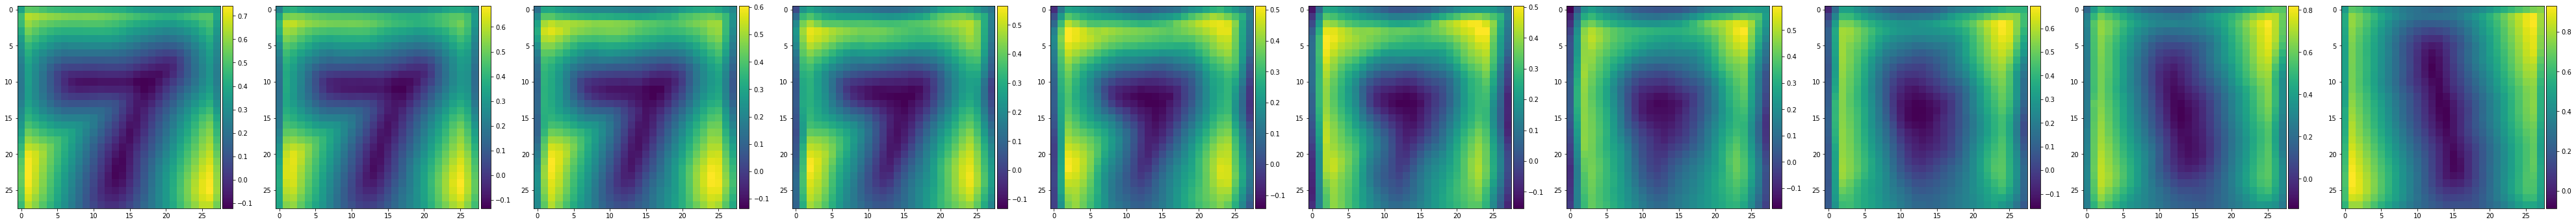

5000
print someth



a,▁
train_lip,█▇▅▄▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_loss,█▄▃▂▁▂▂▂▂▂▂▂▂▁▂▂▂▂▂▂▂▂▁▁▂▂▂▂▁▂▁▁▂▁▁▁▁▁▁▁
train_sdf,█▄▂▂▁▂▂▂▂▂▂▂▂▁▂▂▂▂▂▂▂▂▁▁▂▂▂▂▁▂▁▁▂▁▁▁▁▁▁▁
val_lip,█▅▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_sdf,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
a,0.0001
train_lip,0.0
train_loss,0.00081
train_sdf,0.00081


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name | Type    | Params
---------------------------------
0 | dec  | Decoder | 8.7 K 
---------------------------------
8.7 K     Trainable params
0         Non-trainable params
8.7 K     Total params
0.035     Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

/private/home/yufeiy2/.conda/envs/lasr/lib/python3.8/site-packages/pytorch_lightning/trainer/data_loading.py:132: UserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 80 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


/private/home/yufeiy2/.conda/envs/lasr/lib/python3.8/site-packages/pytorch_lightning/trainer/data_loading.py:132: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 80 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/private/home/yufeiy2/.conda/envs/lasr/lib/python3.8/site-packages/pytorch_lightning/trainer/data_loading.py:432: UserWarning: The number of training samples (2) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

/private/home/yufeiy2/.conda/envs/lasr/lib/python3.8/site-packages/torch/nn/functional.py:3385: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn("Default grid_sample and affine_grid behavior has changed "


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

(10, 28, 28)


<Figure size 432x288 with 0 Axes>

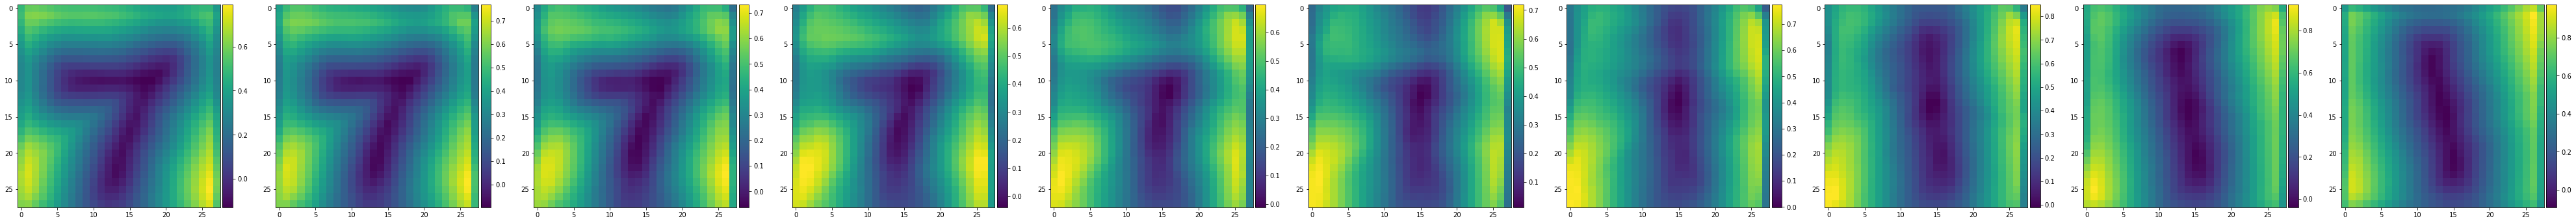

5000


<Figure size 432x288 with 0 Axes>

In [9]:
def my_train_func(alpha):
    # read the current value of parameter "a" from wandb.config
    print('print someth')
    log_name = 'alpha=%g' % alpha
    # run.name = log_name
    wandb.finish()
    wandb_logger = WandbLogger(name=log_name, save_dir='log/', )

    lip_model = SdfDec(alpha, z_dim, [64, 64, 64,], 2, weight_norm='lip', norm_layers=(0, 1, 2, 3))
    # training
    trainer = pl.Trainer(gpus=1, 
        logger=wandb_logger, 
        max_steps=5000,
        check_val_every_n_epoch=100,
        )
    trainer.fit(lip_model, train_loader, val_loader)
    wandb.log({"a": alpha})
    
    device = 'cuda:0'
    lip_model = lip_model.to(device)
    z1 = torch.FloatTensor([[0, ]]).to(device).repeat(1, z_dim)
    z2 = torch.FloatTensor([[1, ]]).to(device).repeat(1, z_dim)
    interpolate(z1, z2, lip_model, 'alpha=%g' % alpha)


for alpha in [1, 1e-1, 1e-2, 1e-3, 1e-4, 0]:
    my_train_func(alpha)


## Optimization wrt observation

- when z = (0.5, 0.5), both succeed


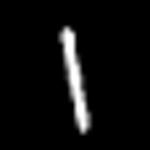
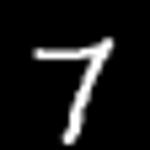


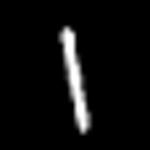
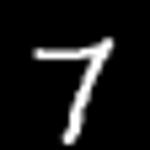

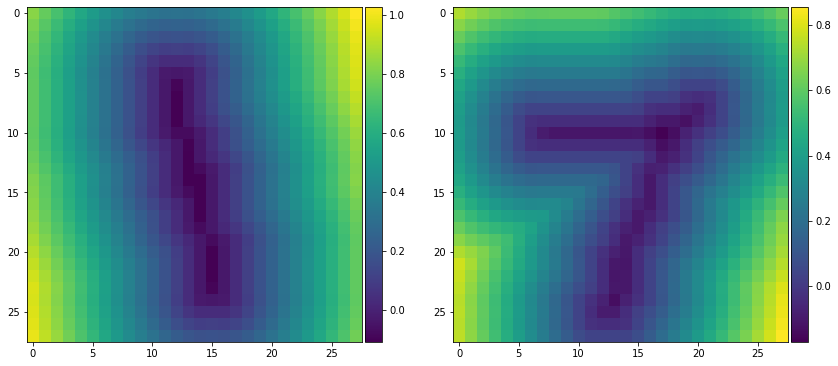

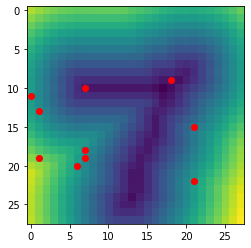

In [10]:
## opt wrt the following

from vis_utils import show_images
z_dim = 2
dataset = ImageSdf(image_list, z_dim, 10)
torch.manual_seed(1234)
x, z, y = dataset[1]
plt.imshow(dataset.edt[1])
H, W = dataset.H, dataset.W
plt.scatter(x[..., 0].detach().numpy() * W//2 + W//2, x[..., 1].detach().numpy() * H//2 + H//2, c='red')

z_start = torch.zeros([1, z_dim]) + 0.5

In [11]:
from decoder import SdfDec

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

def optimize(x, y, z, model: SdfDec, T=1000, title=''):
    """
    x: (P, 2)
    y: (P, 1)
    z: (z_dim)
    model: 
    """
    zz = nn.Parameter(z.view(1, z_dim).clone())
    opt = optim.Adam([zz], 1e-2)

    freq = T // 4
    zz_list = []
    fig, axs = plt.subplots(1, 4, figsize=(7 * 4,7))
    for t in range(T):
        opt.zero_grad()
        z_exp = zz.repeat(x.size(0), 1)
        y_hat = model(x, z_exp)

        loss = 10 * F.mse_loss(y_hat, y)
        wandb.log({'loss': loss}, step=t)
        print(t, loss)
        loss.backward()
        opt.step()

        zz_list.append(zz.cpu().detach().numpy())
        if t % freq == 0:
            image = model.vis_z(zz)
            axs[t//freq].imshow(image[0, 0].cpu().detach().numpy())
            axs[t//freq].title.set_text('t=%d' % t)
    fig.suptitle(title)
    plt.show()
    zz_list = np.array(zz_list).reshape(T, z_dim)
    plt.plot(zz_list[..., 0], zz_list[..., -1])
    plt.title('z_last = %.2f %.2f' % (zz_list[-1, 0].item(), zz_list[-1, 1].item()))
    plt.show()
    return zz_list

        


In [12]:
import os
def vis_opt(folder, lip_model):
    wandb.finish()  

    # z_dim = 2
    # lip_model = SdfDec(1, z_dim, [64, 64, 64,], 2, weight_norm='lip', norm_layers=(0, 1, 2, 3))
    log_dir = 'log/%s/version_None/opt' % folder
    os.makedirs(log_dir, exist_ok=True)
    wandb.init(dir=log_dir, project='opt_lip', name='opt folder')
    ckpt = torch.load('log/%s/version_None/checkpoints/epoch=2499-step=4999.ckpt' % folder)
    lip_model.load_state_dict(ckpt['state_dict'])

    device = 'cuda:0'
    lip_model.to(device)
    optimize(x.to(device), y.to(device), z_start.to(device), lip_model, title=folder)    

a,▁
train_lip,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_loss,█▅▃▄▂▃▂▃▃▃▃▂▂▄▄▂▂▂▃▂▂▂▂▂▂▂▃▂▂▂▂▂▃▂▁▂▁▂▁▁
train_sdf,█▅▃▄▂▃▂▃▃▃▃▂▂▄▄▂▂▂▃▂▂▂▂▂▂▂▃▂▂▂▂▂▃▂▁▂▁▂▁▁
val_lip,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_sdf,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
a,0
train_lip,0.0
train_loss,0.00068
train_sdf,0.00068


0 tensor(0.4653, device='cuda:0', grad_fn=<MulBackward0>)
did not log  sample
1 tensor(0.4500, device='cuda:0', grad_fn=<MulBackward0>)
2 tensor(0.4350, device='cuda:0', grad_fn=<MulBackward0>)
3 tensor(0.4204, device='cuda:0', grad_fn=<MulBackward0>)
4 tensor(0.4053, device='cuda:0', grad_fn=<MulBackward0>)
5 tensor(0.3908, device='cuda:0', grad_fn=<MulBackward0>)
6 tensor(0.3768, device='cuda:0', grad_fn=<MulBackward0>)
7 tensor(0.3627, device='cuda:0', grad_fn=<MulBackward0>)
8 tensor(0.3477, device='cuda:0', grad_fn=<MulBackward0>)
9 tensor(0.3310, device='cuda:0', grad_fn=<MulBackward0>)
10 tensor(0.3156, device='cuda:0', grad_fn=<MulBackward0>)
11 tensor(0.3013, device='cuda:0', grad_fn=<MulBackward0>)
12 tensor(0.2874, device='cuda:0', grad_fn=<MulBackward0>)
13 tensor(0.2738, device='cuda:0', grad_fn=<MulBackward0>)
14 tensor(0.2610, device='cuda:0', grad_fn=<MulBackward0>)
15 tensor(0.2488, device='cuda:0', grad_fn=<MulBackward0>)
16 tensor(0.2364, device='cuda:0', grad_fn=<Mu

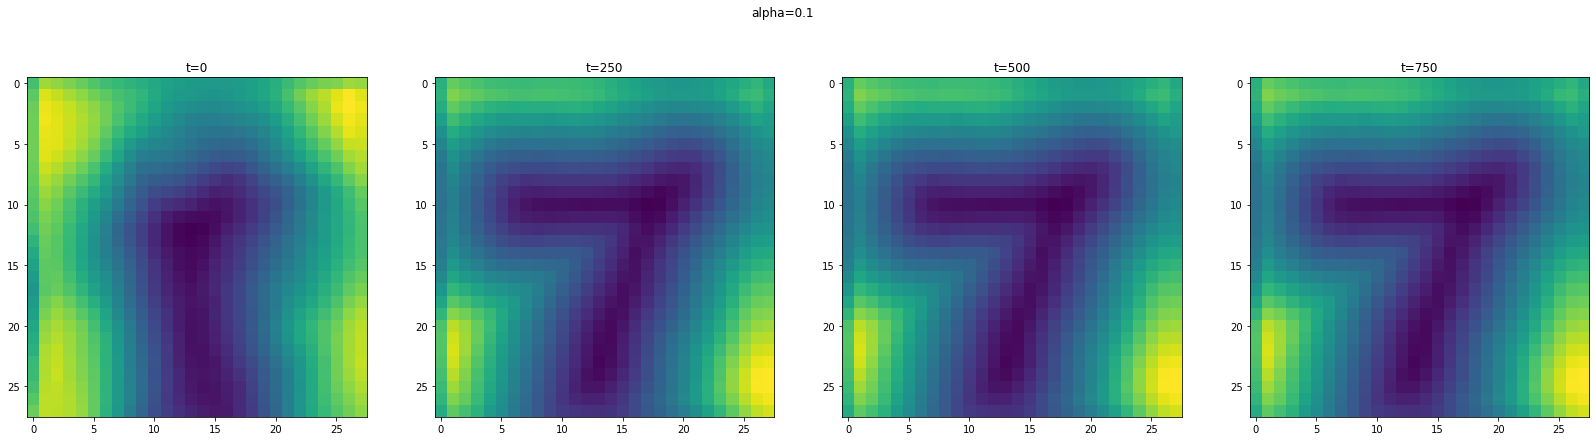

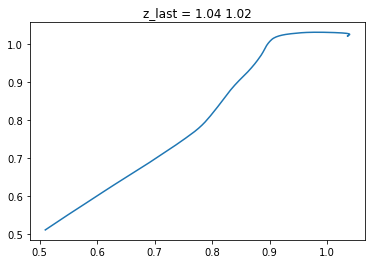

In [13]:

lip_model = SdfDec(1, z_dim, [64, 64, 64,], 2, weight_norm='lip', norm_layers=(0, 1, 2, 3))

vis_opt('alpha=%g' % 0.1, lip_model)

loss,█▃▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
loss,0.00811


0 tensor(0.0874, device='cuda:0', grad_fn=<MulBackward0>)
did not log  sample
1 tensor(0.0843, device='cuda:0', grad_fn=<MulBackward0>)
2 tensor(0.0814, device='cuda:0', grad_fn=<MulBackward0>)
3 tensor(0.0786, device='cuda:0', grad_fn=<MulBackward0>)
4 tensor(0.0756, device='cuda:0', grad_fn=<MulBackward0>)
5 tensor(0.0735, device='cuda:0', grad_fn=<MulBackward0>)
6 tensor(0.0719, device='cuda:0', grad_fn=<MulBackward0>)
7 tensor(0.0705, device='cuda:0', grad_fn=<MulBackward0>)
8 tensor(0.0693, device='cuda:0', grad_fn=<MulBackward0>)
9 tensor(0.0682, device='cuda:0', grad_fn=<MulBackward0>)
10 tensor(0.0672, device='cuda:0', grad_fn=<MulBackward0>)
11 tensor(0.0663, device='cuda:0', grad_fn=<MulBackward0>)
12 tensor(0.0653, device='cuda:0', grad_fn=<MulBackward0>)
13 tensor(0.0643, device='cuda:0', grad_fn=<MulBackward0>)
14 tensor(0.0634, device='cuda:0', grad_fn=<MulBackward0>)
15 tensor(0.0624, device='cuda:0', grad_fn=<MulBackward0>)
16 tensor(0.0615, device='cuda:0', grad_fn=<Mu

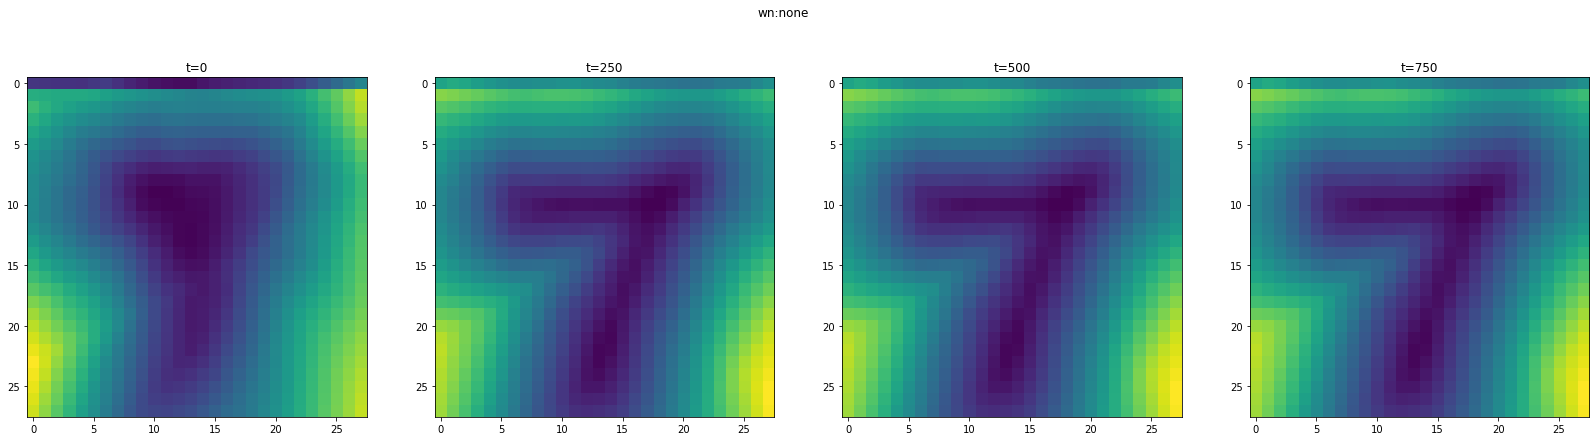

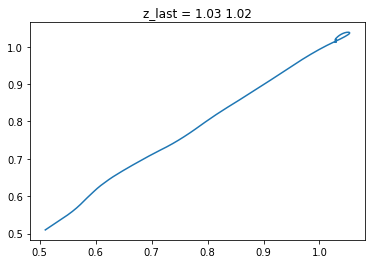

In [14]:

wn_model = SdfDec(1, z_dim, [64, 64, 64,], 2, )
vis_opt('wn:none', wn_model, )

- when z = (0, 0), `wo none` suceed, tried `alpha=1,0.1`, neither converge.

In [15]:
z_start = torch.zeros([1, z_dim])

loss,█▄▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
loss,0.00519


0 tensor(0.9359, device='cuda:0', grad_fn=<MulBackward0>)
did not log  sample
1 tensor(0.9019, device='cuda:0', grad_fn=<MulBackward0>)
2 tensor(0.8670, device='cuda:0', grad_fn=<MulBackward0>)
3 tensor(0.8332, device='cuda:0', grad_fn=<MulBackward0>)
4 tensor(0.8005, device='cuda:0', grad_fn=<MulBackward0>)
5 tensor(0.7697, device='cuda:0', grad_fn=<MulBackward0>)
6 tensor(0.7400, device='cuda:0', grad_fn=<MulBackward0>)
7 tensor(0.7104, device='cuda:0', grad_fn=<MulBackward0>)
8 tensor(0.6826, device='cuda:0', grad_fn=<MulBackward0>)
9 tensor(0.6562, device='cuda:0', grad_fn=<MulBackward0>)
10 tensor(0.6309, device='cuda:0', grad_fn=<MulBackward0>)
11 tensor(0.6080, device='cuda:0', grad_fn=<MulBackward0>)
12 tensor(0.5849, device='cuda:0', grad_fn=<MulBackward0>)
13 tensor(0.5614, device='cuda:0', grad_fn=<MulBackward0>)
14 tensor(0.5388, device='cuda:0', grad_fn=<MulBackward0>)
15 tensor(0.5161, device='cuda:0', grad_fn=<MulBackward0>)
16 tensor(0.4940, device='cuda:0', grad_fn=<Mu

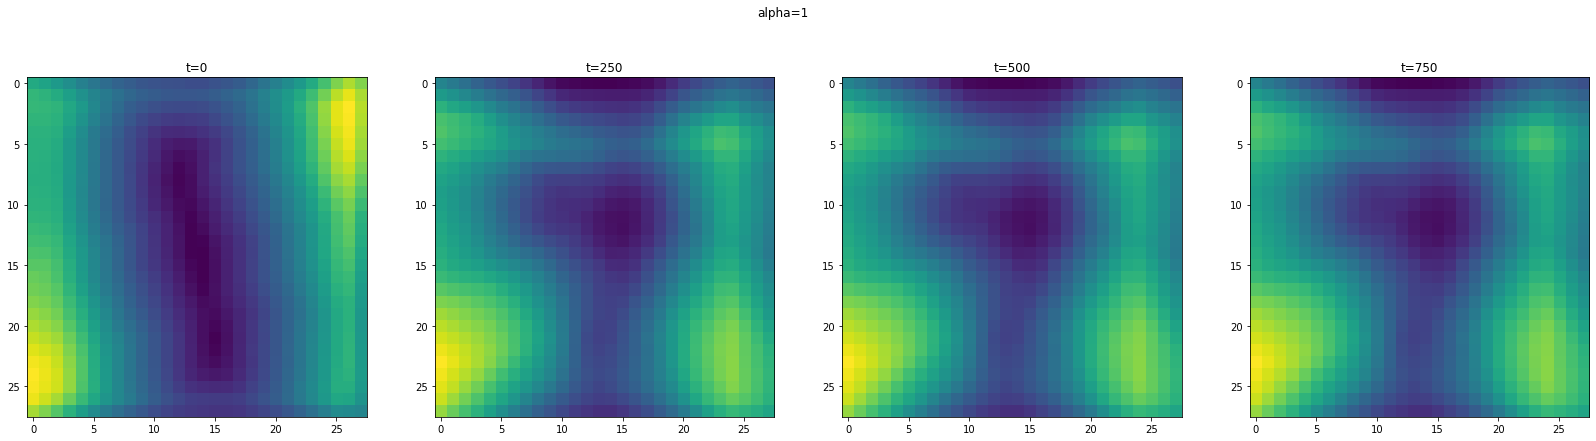

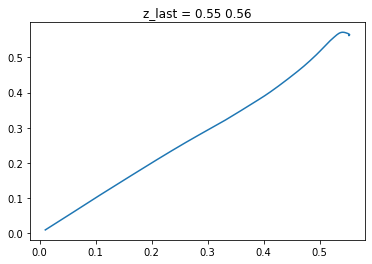

In [16]:

lip_model = SdfDec(1, z_dim, [64, 64, 64,], 2, weight_norm='lip', norm_layers=(0, 1, 2, 3))

vis_opt('alpha=%g' % 1, lip_model)

loss,█▃▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
loss,0.07796


0 tensor(0.8938, device='cuda:0', grad_fn=<MulBackward0>)
did not log  sample
1 tensor(0.8726, device='cuda:0', grad_fn=<MulBackward0>)
2 tensor(0.8497, device='cuda:0', grad_fn=<MulBackward0>)
3 tensor(0.8260, device='cuda:0', grad_fn=<MulBackward0>)
4 tensor(0.8017, device='cuda:0', grad_fn=<MulBackward0>)
5 tensor(0.7768, device='cuda:0', grad_fn=<MulBackward0>)
6 tensor(0.7514, device='cuda:0', grad_fn=<MulBackward0>)
7 tensor(0.7263, device='cuda:0', grad_fn=<MulBackward0>)
8 tensor(0.6998, device='cuda:0', grad_fn=<MulBackward0>)
9 tensor(0.6740, device='cuda:0', grad_fn=<MulBackward0>)
10 tensor(0.6488, device='cuda:0', grad_fn=<MulBackward0>)
11 tensor(0.6239, device='cuda:0', grad_fn=<MulBackward0>)
12 tensor(0.5988, device='cuda:0', grad_fn=<MulBackward0>)
13 tensor(0.5744, device='cuda:0', grad_fn=<MulBackward0>)
14 tensor(0.5522, device='cuda:0', grad_fn=<MulBackward0>)
15 tensor(0.5313, device='cuda:0', grad_fn=<MulBackward0>)
16 tensor(0.5099, device='cuda:0', grad_fn=<Mu

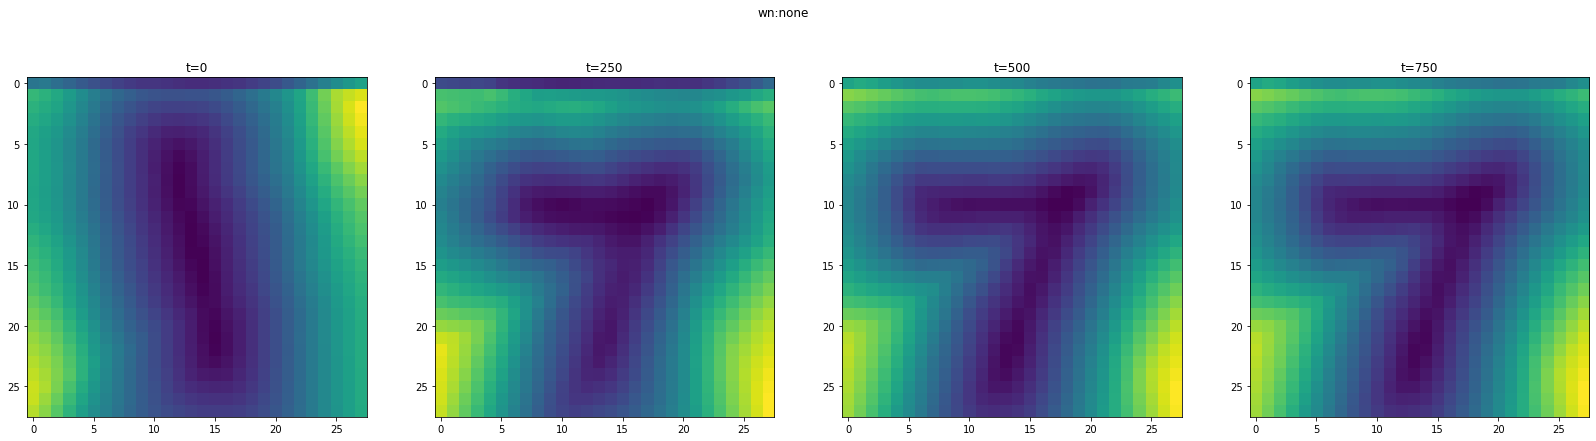

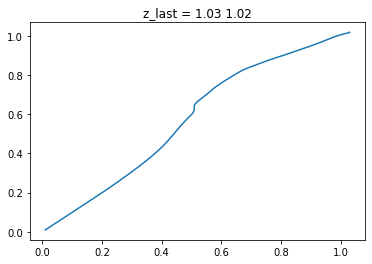

In [17]:

wn_model = SdfDec(1, z_dim, [64, 64, 64,], 2, )
vis_opt('wn:none', wn_model, )

- when z = (1, 0), `wo none` suceed, tried `alpha=1,0.1`, neither converge.

In [18]:
z_start = torch.zeros([1, z_dim]); z_start[:, 0] = 1

loss,█▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
loss,0.00519


0 tensor(0.5090, device='cuda:0', grad_fn=<MulBackward0>)
did not log  sample
1 tensor(0.4952, device='cuda:0', grad_fn=<MulBackward0>)
2 tensor(0.4814, device='cuda:0', grad_fn=<MulBackward0>)
3 tensor(0.4679, device='cuda:0', grad_fn=<MulBackward0>)
4 tensor(0.4554, device='cuda:0', grad_fn=<MulBackward0>)
5 tensor(0.4438, device='cuda:0', grad_fn=<MulBackward0>)
6 tensor(0.4321, device='cuda:0', grad_fn=<MulBackward0>)
7 tensor(0.4201, device='cuda:0', grad_fn=<MulBackward0>)
8 tensor(0.4077, device='cuda:0', grad_fn=<MulBackward0>)
9 tensor(0.3941, device='cuda:0', grad_fn=<MulBackward0>)
10 tensor(0.3804, device='cuda:0', grad_fn=<MulBackward0>)
11 tensor(0.3667, device='cuda:0', grad_fn=<MulBackward0>)
12 tensor(0.3522, device='cuda:0', grad_fn=<MulBackward0>)
13 tensor(0.3379, device='cuda:0', grad_fn=<MulBackward0>)
14 tensor(0.3238, device='cuda:0', grad_fn=<MulBackward0>)
15 tensor(0.3117, device='cuda:0', grad_fn=<MulBackward0>)
16 tensor(0.3008, device='cuda:0', grad_fn=<Mu

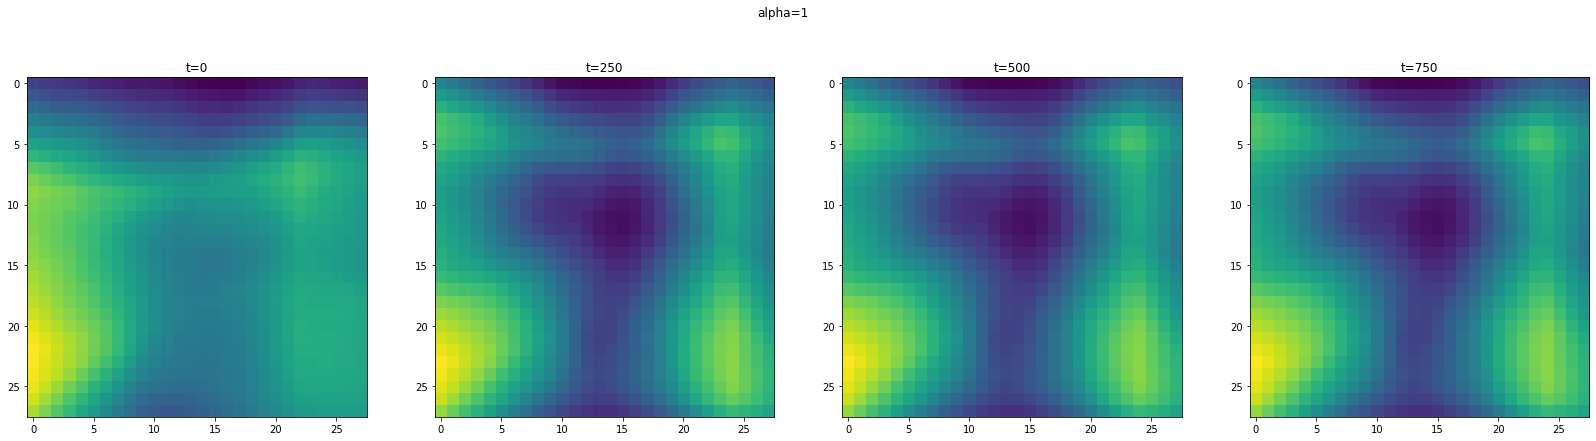

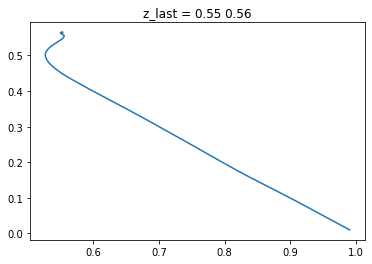

In [19]:

lip_model = SdfDec(1, z_dim, [64, 64, 64,], 2, weight_norm='lip', norm_layers=(0, 1, 2, 3))

vis_opt('alpha=%g' % 1, lip_model)   

loss,█▃▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
loss,0.07796


0 tensor(0.3032, device='cuda:0', grad_fn=<MulBackward0>)
did not log  sample
1 tensor(0.3004, device='cuda:0', grad_fn=<MulBackward0>)
2 tensor(0.2976, device='cuda:0', grad_fn=<MulBackward0>)
3 tensor(0.2948, device='cuda:0', grad_fn=<MulBackward0>)
4 tensor(0.2924, device='cuda:0', grad_fn=<MulBackward0>)
5 tensor(0.2899, device='cuda:0', grad_fn=<MulBackward0>)
6 tensor(0.2870, device='cuda:0', grad_fn=<MulBackward0>)
7 tensor(0.2837, device='cuda:0', grad_fn=<MulBackward0>)
8 tensor(0.2807, device='cuda:0', grad_fn=<MulBackward0>)
9 tensor(0.2779, device='cuda:0', grad_fn=<MulBackward0>)
10 tensor(0.2748, device='cuda:0', grad_fn=<MulBackward0>)
11 tensor(0.2709, device='cuda:0', grad_fn=<MulBackward0>)
12 tensor(0.2658, device='cuda:0', grad_fn=<MulBackward0>)
13 tensor(0.2594, device='cuda:0', grad_fn=<MulBackward0>)
14 tensor(0.2528, device='cuda:0', grad_fn=<MulBackward0>)
15 tensor(0.2462, device='cuda:0', grad_fn=<MulBackward0>)
16 tensor(0.2396, device='cuda:0', grad_fn=<Mu

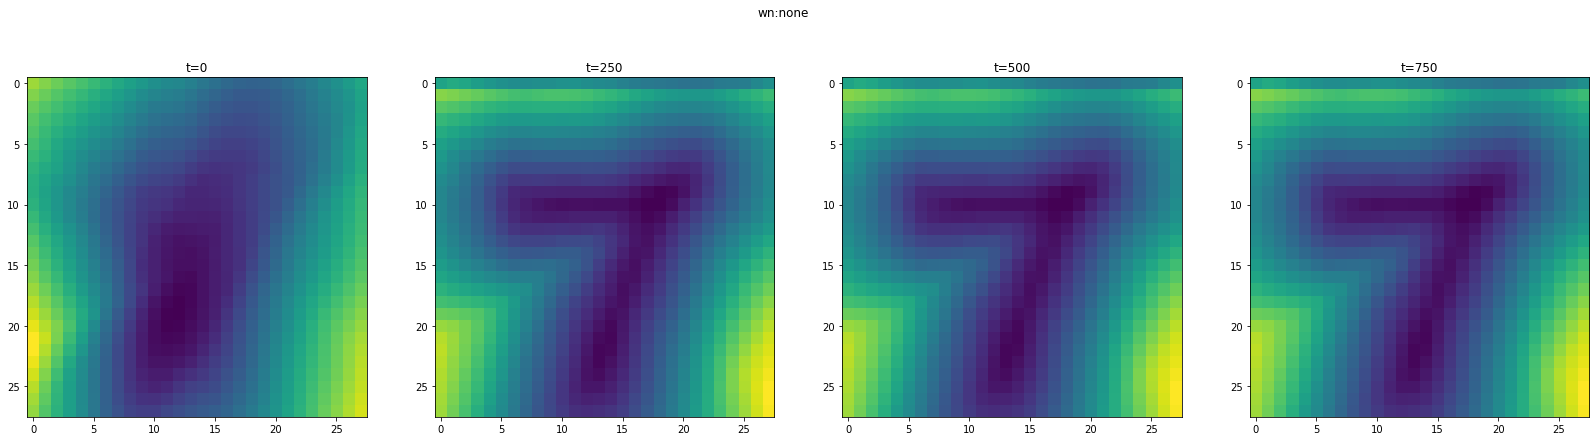

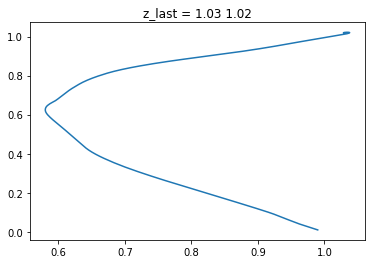

In [20]:

wn_model = SdfDec(1, z_dim, [64, 64, 64,], 2, )
vis_opt('wn:none', wn_model, )